# Constructing a WIMP Spectrum

The point of this notebook is to construct what a Si low-mass WIMP spectrum would look like at very low energy, with an HVeV detector biased to ~100V in the 1-5 e/h pair region. This is to illustrate how a variance in the nuclear recoil charge production can produce large effects. 

## Get the WIMP CDF

In [1]:
#get the stored CDF from a file
import dataPython as dp
import numpy as np
#data = dp.getXYZdata('WIMP_xsections/WIMP_Si_PDF_CDF_0.5GeV_1e-06keV_steps_fmt.txt')
data = dp.getXYZdata('WIMP_xsections/WIMP_Si_PDF_CDF_1GeV_5e-05keV_steps_fmt.txt')

#convert to numpy arrays
ekev = np.asarray(data['xx'])
pdf = np.asarray(data['yy'])
cdf = np.asarray(data['zz'])

print(data.keys())

dict_keys(['xx', 'yy', 'zz'])


In [2]:
#set up a plot 
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerLine2D
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')

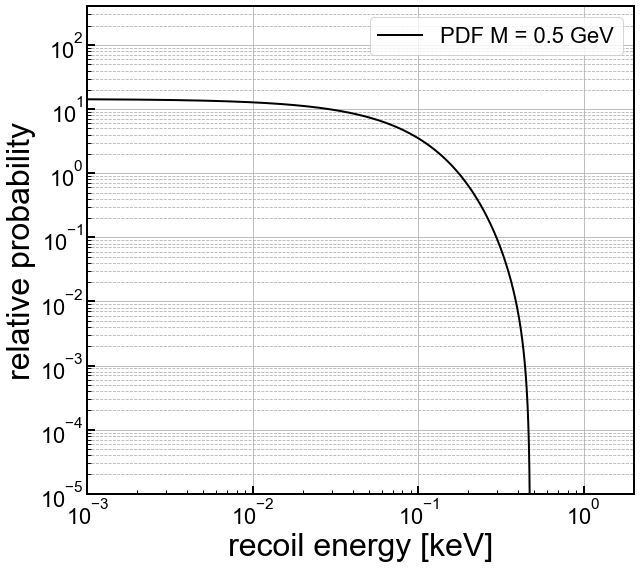

In [3]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

xmin = 0.001
xmax = 2
X = np.arange(xmin,xmax,0.01)

ax1.plot(ekev,pdf,'k-',label='PDF M = 0.5 GeV')


ymin=1e-5
ymax=400


ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel('recoil energy [keV]',**axis_font)
ax1.set_ylabel('relative probability',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figures.png')
plt.show()

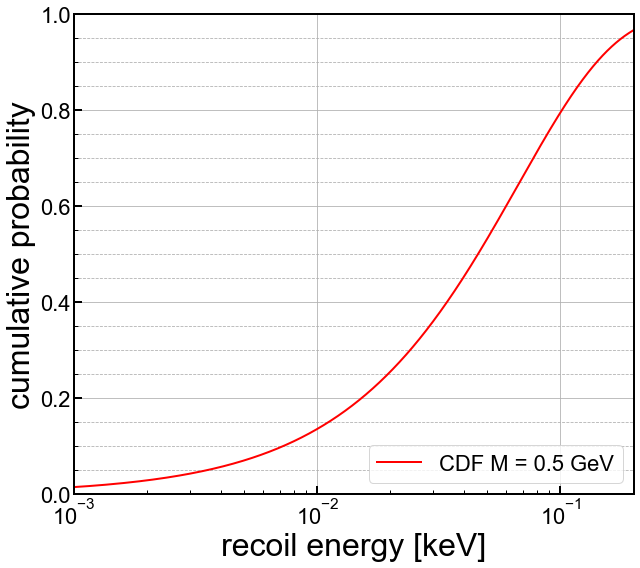

In [4]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

xmin = 0.001
xmax = 0.2
X = np.arange(xmin,xmax,0.01)

ax1.plot(ekev,cdf,'r-',label='CDF M = 0.5 GeV')


ymin=1e-5
ymax=1


ax1.set_yscale('linear')
ax1.set_xscale('log')
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel('recoil energy [keV]',**axis_font)
ax1.set_ylabel('cumulative probability',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=4,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figures.png')
plt.show()

## Interpolate Inverted WIMP CDF and Generate Er

In [5]:
import scipy.interpolate as inter

#find first place cdf is unity
idx = np.arange(0,np.shape(cdf)[0])
print(idx)
idx_unity = idx[cdf>=1]
min_unity = np.min(idx_unity)
cdf_cut = cdf[idx<=min_unity]
ekev_cut = ekev[idx<=min_unity]

g = inter.InterpolatedUnivariateSpline (cdf_cut, ekev_cut, k=3)

[   0    1    2 ... 9997 9998 9999]


In [6]:
print(g(0.65))

0.06796898360512178


## Grab the Yield Model (DAMIC) and Generate N

In [7]:
import damic_y as dy 

#a spline extrapolation to DAMIC data
damic_y = dy.getDAMICy()
damic_yv = np.vectorize(damic_y) #vectorize it

In [8]:
#dream up some constants
F = 0.1
Fv=[0.1,1,3]
eps = 3.8 #for silicon
V = 200

Ntot = 1000000

#get a bunch of recoil energies and the average numbers
u = np.random.uniform(0,1,(Ntot,))
Er = g(u)*1000 #use eV
print(Er[0:10])
Nav = Er*damic_yv(Er)*(1/eps)
print(Nav[0:10])

#Increase these arrays to hold different Fano realizations
print(np.shape(Fv)[0])
Nav_f = np.outer(Nav,np.ones(np.shape(Fv)))
Er_f = np.outer(Er,np.ones(np.shape(Fv)))
F_f = np.outer(np.ones(np.shape(Er)),Fv)

print(np.shape(Nav_f))
print(np.shape(Er_f))
print(np.shape(F_f))

#approximate a discrete normal dist by rounding
N = np.round(np.random.normal(Nav_f,np.sqrt(F_f*(Nav_f))))
print(np.shape(N))
print(N[0:10])
#N = np.round(np.random.normal((Nav,np.sqrt(F*(Nav)),np.shape(Nav)))) #discretize a normal distribution
#print(N[0:10])

#get the total phonon energy
Ep = N*V + Er_f
Ep = Ep + np.random.normal(0,14,np.shape(Ep))
Ep_cal = Ep/V
print(Ep[0:10])
print(Ep_cal[0:10])



[  6.48388793   1.17350615   0.32354147  60.15928649  64.24281698
  12.00417964   0.19691777 167.75108798  81.82269344  49.04348909]
[6.48664827e-02 1.15315693e-02 3.17008700e-03 7.07248981e-01
 7.63612240e-01 1.22299891e-01 1.92858041e-03 2.52232282e+00
 1.01797161e+00 5.59091740e-01]
3
(1000000, 3)
(1000000, 3)
(1000000, 3)
(1000000, 3)
[[ 0. -0. -0.]
 [ 0. -0. -0.]
 [ 0. -0.  0.]
 [ 1.  1.  0.]
 [ 1. -2. -0.]
 [ 0.  0.  0.]
 [ 0. -0.  0.]
 [ 3.  4.  5.]
 [ 1.  1.  2.]
 [ 0.  0.  3.]]
[[   3.35100937    8.05998251   -7.43801976]
 [   5.09192822  -25.84118167   24.01329953]
 [ -18.67481871   -6.67151258  -14.28940699]
 [ 236.34464561  255.5446847    64.6710467 ]
 [ 284.99804427 -344.37161828   58.61235322]
 [   8.84953984   37.38612966   23.77264477]
 [ -31.15382066    5.510396      3.80578634]
 [ 756.24695764  968.24951514 1137.24986397]
 [ 271.87324887  273.63522916  485.37737281]
 [  57.44774877   41.93261155  643.09091941]]
[[ 0.01675505  0.04029991 -0.0371901 ]
 [ 0.02545964 -0.1

In [9]:
nbins = 500
n,nx = np.histogram(Ep_cal[:,0],nbins,range=(0,5))

xc = (nx[:-1] + nx[1:]) / 2

#get histogams for all the Fano Factors
n_f = np.empty((np.shape(n)[0],0))


for i,f in enumerate(Fv):
    temp_n,temp_nx = np.histogram(Ep_cal[:,i],nbins,range=(0,5))
    temp_n = np.reshape(temp_n,(np.shape(n_f)[0],1))
    print(np.shape(temp_n))
    n_f = np.append(n_f,temp_n,1)
    
print(n_f[0:10,:])

(500, 1)
(500, 1)
(500, 1)
[[13088. 11407.  9164.]
 [14375. 12125.  9574.]
 [15311. 13112. 10225.]
 [16418. 13699. 10540.]
 [16990. 14256. 10942.]
 [17988. 14567. 11275.]
 [18213. 14889. 11116.]
 [18408. 14765. 11094.]
 [18644. 14479. 10880.]
 [18728. 14395. 10496.]]


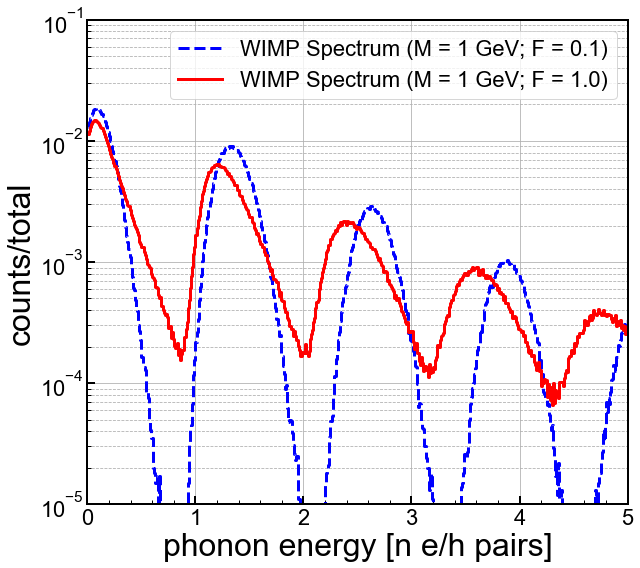

In [10]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

X = np.arange(0,5,0.01)

label1 = 'WIMP Spectrum (M = 1 GeV; F = {0:1.1f})'.format(Fv[0])
ax1.step(xc,n_f[:,0]/Ntot, where='mid',color='b', linestyle='--', label=label1, linewidth=3)
label2 = 'WIMP Spectrum (M = 1 GeV; F = {0:1.1f})'.format(Fv[1])
ax1.step(xc,n_f[:,1]/Ntot, where='mid',color='r', linestyle='-', label=label2, linewidth=3)
label3 = 'WIMP Spectrum (M = 1 GeV; F = {0:1.1f})'.format(Fv[2])
#ax1.step(xc,n_f[:,2]/Ntot, where='mid',color='g', linestyle='-', label=label3, linewidth=3)
#ax1.plot(X,gaus(X,*popt),'k-',label='fit')


ymin=0.00001
ymax=0.1


ax1.set_yscale('log')
ax1.set_xlim(0, 5)
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel('phonon energy [n e/h pairs]',**axis_font)
ax1.set_ylabel('counts/total',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
plt.savefig('figures/WIMPs_1GeV_HVeV.png')
plt.show()